This IPython Notebook introduces the use of the `openmc.mgxs` module to calculate multi-energy-group and multi-delayed-group cross sections for an infinite homogeneous medium. In particular, this Notebook introduces the the following features:

* Creation of multi-delayed-group cross sections for an **infinite homogeneous medium**
* Calculation of delayed neutron precursor concentrations

**Note:** This Notebook illustrates the use of [Pandas](http://pandas.pydata.org/) `DataFrames` to containerize multi-group cross section data. We recommend using [Pandas](http://pandas.pydata.org/) >v0.15.0 or later since OpenMC's Python API leverages the multi-indexing feature included in the most recent releases of [Pandas](http://pandas.pydata.org/).

## Introduction to Multi-Delayed-Group Cross Sections (MDGXS)

Many Monte Carlo particle transport codes, including OpenMC, use continuous-energy nuclear cross section data. However, most deterministic neutron transport codes use *multi-group cross sections* defined over discretized energy bins or *energy groups*. Furthermore, kinetics calculations typically separate out parameters that involve delayed neutrons into prompt and delayed components and further subdivide delayed components by delayed groups. An example is the energy spectrum for prompt and delayed neutrons for U-235 and Pu-239 computed for a light water reactor spectrum.

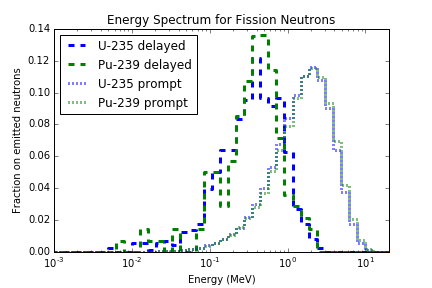

In [1]:
from IPython.display import Image
Image(filename='images/mdgxs.png', width=350)

A variety of tools employing different methodologies have been developed over the years to compute multi-group cross sections for certain applications, including NJOY (LANL), MC$^2$-3 (ANL), and Serpent (VTT). The `openmc.mgxs` Python module is designed to leverage OpenMC's tally system to calculate multi-group cross sections with arbitrary energy discretizations and different delayed group models (e.g. 6, 7, or 8 delayed group models) for fine-mesh heterogeneous deterministic neutron transport applications.

Before proceeding to illustrate how one may use the `openmc.mgxs` module, it is worthwhile to define the general equations used to calculate multi-energy-group and multi-delayed-group cross sections. This is only intended as a brief overview of the methodology used by `openmc.mgxs` - we refer the interested reader to the large body of literature on the subject for a more comprehensive understanding of this complex topic.

### Introductory Notation
The continuous real-valued microscopic cross section may be denoted $\sigma_{n,x}(\mathbf{r}, E)$ for position vector $\mathbf{r}$, energy $E$, nuclide $n$ and interaction type $x$. Similarly, the scalar neutron flux may be denoted by $\Phi(\mathbf{r},E)$ for position $\mathbf{r}$ and energy $E$. **Note**: Although nuclear cross sections are dependent on the temperature $T$ of the interacting medium, the temperature variable is neglected here for brevity.

### Spatial and Energy Discretization
The energy domain for critical systems such as thermal reactors spans more than 10 orders of magnitude of neutron energies from 10$^{-5}$ - 10$^7$ eV. The multi-group approximation discretization divides this energy range into one or more energy groups. In particular, for $G$ total groups, we denote an energy group index $g$ such that $g \in \{1, 2, ..., G\}$. The energy group indices are defined such that the smaller group the higher the energy, and vice versa. The integration over neutron energies across a discrete energy group is commonly referred to as **energy condensation**.

The delayed neutrons created from fissions are created from > 30 delayed neutron precursors. Modeling each of the delayed neutron precursors is possible, but this approach has not recieved much attention due to large uncertainties in certain precursors. Therefore, the delayed neutrons are often combined into "delayed groups" that have a set time constant, $\lambda_d$. Some cross section libraries use the same group time constants for all nuclides (e.g. JEFF 3.1) while other libraries use different time constants for all nuclides (e.g. ENDF/B-VII.1). Multi-delayed-group cross sections can either be created with the entire delayed group set, a subset of delayed groups, or integrated over all delayed groups.

Multi-group cross sections are computed for discretized spatial zones in the geometry of interest. The spatial zones may be defined on a structured and regular fuel assembly or pin cell mesh, an arbitrary unstructured mesh or the constructive solid geometry used by OpenMC. For a geometry with $K$ distinct spatial zones, we designate each spatial zone an index $k$ such that $k \in \{1, 2, ..., K\}$. The volume of each spatial zone is denoted by $V_{k}$. The integration over discrete spatial zones is commonly referred to as **spatial homogenization**.

### General Scalar-Flux Weighted MDGXS
The multi-group cross sections computed by `openmc.mgxs` are defined as a *scalar flux-weighted average* of the microscopic cross sections across each discrete energy group. This formulation is employed in order to preserve the reaction rates within each energy group and spatial zone. In particular, spatial homogenization and energy condensation are used to compute the general multi-group cross section. For instance, the delayed-nu-fission multi-energy-group and multi-delayed-group cross section, $\nu_d \sigma_{f,x,k,g}$, can be computed as follows:

$$\nu_d \sigma_{n,x,k,g} = \frac{\int_{E_{g}}^{E_{g-1}}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r} \nu_d \sigma_{f,x}(\mathbf{r},E')\Phi(\mathbf{r},E')}{\int_{E_{g}}^{E_{g-1}}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r}\Phi(\mathbf{r},E')}$$

This scalar flux-weighted average microscopic cross section is computed by `openmc.mgxs` for only the delayed-nu-fission and delayed neutron fraction reaction type at the moment. These double integrals are stochastically computed with OpenMC's tally system - in particular, [filters](https://mit-crpg.github.io/openmc/pythonapi/filter.html) on the energy range and spatial zone (material, cell, universe, or mesh) define the bounds of integration for both numerator and denominator.

### Multi-Group Prompt and Delayed Fission Spectrum
The energy spectrum of neutrons emitted from fission is denoted by $\chi_{n}(\mathbf{r},E' \rightarrow E'')$ for incoming and outgoing energies $E'$ and $E''$, respectively. Unlike the multi-group cross sections $\sigma_{n,x,k,g}$ considered up to this point, the fission spectrum is a probability distribution and must sum to unity. The outgoing energy is typically much less dependent on the incoming energy for fission than for scattering interactions. As a result, it is common practice to integrate over the incoming neutron energy when computing the multi-group fission spectrum. The fission spectrum may be simplified as $\chi_{n}(\mathbf{r},E)$ with outgoing energy $E$.

Computing the cumulative energy spectrum of emitted neutrons, $\chi_{n}(\mathbf{r},E)$, has been presented in the `mgxs-part-i.ipynb` notebook. Here, we will present the energy spectrum of prompt and delayed emission neutrons, $\chi_{n,p}(\mathbf{r},E)$ and $\chi_{n,d}(\mathbf{r},E)$, respectively. Unlike the multi-group cross sections defined up to this point, the multi-group fission spectrum is weighted by the fission production rate rather than the scalar flux. This formulation is intended to preserve the total fission production rate in the multi-group deterministic calculation. In order to mathematically define the multi-group fission spectrum, we denote the microscopic fission cross section as $\sigma_{n,f}(\mathbf{r},E)$ and the average number of neutrons emitted from fission interactions with nuclide $n$ as $\nu_{n,p}(\mathbf{r},E)$ and $\nu_{n,d}(\mathbf{r},E)$ for prompt and delayed neutrons, respectively. The multi-group fission spectrum $\chi_{n,k,g,d}$ is then the probability of fission neutrons emitted into energy group $g$ and delayed group $d$. There are not prompt groups, so inserting $p$ in place of $d$ just denotes all prompt neutrons. 

Similar to before, spatial homogenization and energy condensation are used to find the multi-energy-group and multi-delayed-group fission spectrum $\chi_{n,k,g,d}$ as follows:

$$\chi_{n,k,g',d} = \frac{\int_{E_{g'}}^{E_{g'-1}}\mathrm{d}E''\int_{0}^{\infty}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r}\chi_{n,d}(\mathbf{r},E'\rightarrow E'')\nu_{n,d}(\mathbf{r},E')\sigma_{n,f}(\mathbf{r},E')\Phi(\mathbf{r},E')}{\int_{0}^{\infty}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r}\nu_{n,d}(\mathbf{r},E')\sigma_{n,f}(\mathbf{r},E')\Phi(\mathbf{r},E')}$$

The fission production-weighted multi-energy-group and multi-delayed-group fission spectrum for delayed neutrons is computed using OpenMC tallies with energy in, energy out, and delayed group filters. Alternatively, the delayed group filter can be omitted to compute the fission spectrum integrated over all delayed groups.

This concludes our brief overview on the methodology to compute multi-energy-group and multi-delayed-group cross sections. The following sections detail more concretely how users may employ the `openmc.mgxs` module to power simulation workflows requiring multi-group cross sections for downstream deterministic calculations.

## Generate Input Files

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import openmc
import openmc.mgxs as mgxs

First we need to define materials that will be used in the problem. Before defining a material, we must create nuclides that are used in the material.

In [3]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H1')
o16 = openmc.Nuclide('O16')
u235 = openmc.Nuclide('U235')
u238 = openmc.Nuclide('U238')
pu239 = openmc.Nuclide('Pu239')
zr90 = openmc.Nuclide('Zr90')

With the nuclides we defined, we will now create a material for the homogeneous medium.

In [4]:
# Instantiate a Material and register the Nuclides
inf_medium = openmc.Material(name='moderator')
inf_medium.set_density('g/cc', 5.)
inf_medium.add_nuclide(h1,  0.03)
inf_medium.add_nuclide(o16, 0.015)
inf_medium.add_nuclide(u235 , 0.0001)
inf_medium.add_nuclide(u238 , 0.007)
inf_medium.add_nuclide(pu239, 0.00003)
inf_medium.add_nuclide(zr90, 0.002)

With our material, we can now create a `Materials` object that can be exported to an actual XML file.

In [5]:
# Instantiate a Materials collection and export to XML
materials_file = openmc.Materials([inf_medium])
materials_file.default_xs = '71c'
materials_file.export_to_xml()

Now let's move on to the geometry. This problem will be a simple square cell with reflective boundary conditions to simulate an infinite homogeneous medium. The first step is to create the outer bounding surfaces of the problem.

In [6]:
# Instantiate boundary Planes
min_x = openmc.XPlane(boundary_type='reflective', x0=-0.63)
max_x = openmc.XPlane(boundary_type='reflective', x0=0.63)
min_y = openmc.YPlane(boundary_type='reflective', y0=-0.63)
max_y = openmc.YPlane(boundary_type='reflective', y0=0.63)

With the surfaces defined, we can now create a cell that is defined by intersections of half-spaces created by the surfaces.

In [7]:
# Instantiate a Cell
cell = openmc.Cell(cell_id=1, name='cell')

# Register bounding Surfaces with the Cell
cell.region = +min_x & -max_x & +min_y & -max_y

# Fill the Cell with the Material
cell.fill = inf_medium

OpenMC requires that there is a "root" universe. Let us create a root universe and add our square cell to it.

In [8]:
# Instantiate Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(cell)

We now must create a geometry that is assigned a root universe and export it to XML.

In [9]:
# Create Geometry and set root Universe
openmc_geometry = openmc.Geometry()
openmc_geometry.root_universe = root_universe

# Export to "geometry.xml"
openmc_geometry.export_to_xml()

Next, we must define simulation parameters. In this case, we will use 10 inactive batches and 40 active batches each with 2500 particles.

In [10]:
# OpenMC simulation parameters
batches = 50
inactive = 10
particles = 5000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': True}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.63, -0.63, -0.63, 0.63, 0.63, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

Now we are ready to generate multi-group cross sections! First, let's define a 100-energy-group structure and 1-energy-group structure using the built-in `EnergyGroups` class. We will also create a 6-delayed-group list.

In [11]:
# Instantiate a 100-group EnergyGroups object
energy_groups = mgxs.EnergyGroups()
energy_groups.group_edges = np.logspace(-9,1.3,101)

# Instantiate a 1-group EnergyGroups object
one_group = mgxs.EnergyGroups()
one_group.group_edges = np.array([energy_groups.group_edges[0], energy_groups.group_edges[-1]])

delayed_groups = list(range(1,7))

We can now use the `EnergyGroups` object and delayed group list, along with our previously created materials and geometry, to instantiate some `MGXS` objects from the `openmc.mgxs` module. In particular, the following are subclasses of the generic and abstract `MGXS` class:

* `TotalXS`
* `TransportXS`
* `NuTransportXS`
* `AbsorptionXS`
* `CaptureXS`
* `FissionXS`
* `NuFissionXS`
* `KappaFissionXS`
* `ScatterXS`
* `NuScatterXS`
* `ScatterMatrixXS`
* `NuScatterMatrixXS`
* `Chi`
* `ChiPrompt`
* `InverseVelocity`
* `PromptNuFissionXS`

A separate abstract `MDGXS` class is used for cross-sections and parameters that involve delayed neutrons. The subclasses of `MDGXS` include:

* `DelayedNuFissionXS`
* `ChiDelayed`
* `Beta`
* `DecayRate`

These classes provide us with an interface to generate the tally inputs as well as perform post-processing of OpenMC's tally data to compute the respective multi-group cross sections. In this case, let's create the multi-group chi-prompt, chi-delayed, and prompt-nu-fission cross sections with our 100-energy-group structure and multi-group delayed-nu-fission and beta cross sections with our 100-energy-group and 6-delayed-group structures. 

In [12]:
# Instantiate a few different sections
chi_prompt = mgxs.ChiPrompt(domain=cell, groups=energy_groups, by_nuclide=True)
prompt_nu_fission = mgxs.PromptNuFissionXS(domain=cell, groups=energy_groups, by_nuclide=True)
chi_delayed = mgxs.ChiDelayed(domain=cell, energy_groups=energy_groups, by_nuclide=True)
delayed_nu_fission = mgxs.DelayedNuFissionXS(domain=cell, energy_groups=energy_groups, delayed_groups=delayed_groups, by_nuclide=True)
beta = mgxs.Beta(domain=cell, energy_groups=energy_groups, delayed_groups=delayed_groups, by_nuclide=True)
decay_rate = mgxs.DecayRate(domain=cell, energy_groups=one_group, delayed_groups=delayed_groups, by_nuclide=True)

chi_prompt.nuclides = ['U235', 'Pu239']
prompt_nu_fission.nuclides = ['U235', 'Pu239']
chi_delayed.nuclides = ['U235', 'Pu239']
delayed_nu_fission.nuclides = ['U235', 'Pu239']
beta.nuclides = ['U235', 'Pu239']
decay_rate.nuclides = ['U235', 'Pu239']

Each multi-group cross section object stores its tallies in a Python dictionary called `tallies`. We can inspect the tallies in the dictionary for our `Decay Rate` object as follows. 

In [13]:
decay_rate.tallies

OrderedDict([('delayed-nu-fission', Tally
              	ID             =	10000
              	Name           =	
              	Filters        =	
                              		cell	[1]
                              		delayedgroup	[1 2 3 4 5 6]
                              		energy	[  1.00000000e-09   1.99526231e+01]
              	Nuclides       =	U235 Pu239 
              	Scores         =	['delayed-nu-fission']
              	Estimator      =	analog), ('decay-rate', Tally
              	ID             =	10001
              	Name           =	
              	Filters        =	
                              		cell	[1]
                              		delayedgroup	[1 2 3 4 5 6]
                              		energy	[  1.00000000e-09   1.99526231e+01]
              	Nuclides       =	U235 Pu239 
              	Scores         =	['decay-rate']
              	Estimator      =	analog)])

The `Beta` object includes tracklength tallies for the 'nu-fission' and 'delayed-nu-fission' scores in the 100-energy-group and 6-delayed-group structure in cell 1. Now that each `MGXS` and `MDGXS` object contains the tallies that it needs, we must add these tallies to a `Tallies` object to generate the "tallies.xml" input file for OpenMC.

In [14]:
# Instantiate an empty Tallies object
tallies_file = openmc.Tallies()

# Add chi-prompt tallies to the tallies file
tallies_file += chi_prompt.tallies.values()

# Add prompt-nu-fission tallies to the tallies file
tallies_file += prompt_nu_fission.tallies.values()

# Add chi-delayed tallies to the tallies file
tallies_file += chi_delayed.tallies.values()

# Add delayed-nu-fission tallies to the tallies file
tallies_file += delayed_nu_fission.tallies.values()

# Add beta tallies to the tallies file
tallies_file += beta.tallies.values()

# Add decay rate tallies to the tallies file
tallies_file += decay_rate.tallies.values()

# Export to "tallies.xml"
tallies_file.export_to_xml()

Now we a have a complete set of inputs, so we can go ahead and run our simulation.

In [15]:
# Run OpenMC
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files. We begin our analysis by instantiating a `StatePoint` object. 

In [16]:
# Load the last statepoint file
sp = openmc.StatePoint('statepoint.50.h5')

In addition to the statepoint file, our simulation also created a summary file which encapsulates information about the materials and geometry. By default, a `Summary` object is automatically linked when a `StatePoint` is loaded. This is necessary for the `openmc.mgxs` module to properly process the tally data.

The statepoint is now ready to be analyzed by our multi-group cross sections. We simply have to load the tallies from the `StatePoint` into each object as follows and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [17]:
# Load the tallies from the statepoint into each MGXS object
chi_prompt.load_from_statepoint(sp)
prompt_nu_fission.load_from_statepoint(sp)
chi_delayed.load_from_statepoint(sp)
delayed_nu_fission.load_from_statepoint(sp)
beta.load_from_statepoint(sp)
decay_rate.load_from_statepoint(sp)

Voila! Our multi-group cross sections are now ready to rock 'n roll!

## Extracting and Storing MGXS Data

Let's first inspect our delayed-nu-fission section by printing it to the screen after condensing the cross section down to one group.

In [18]:
delayed_nu_fission.get_condensed_xs(one_group).get_xs()

array([[  5.14239169e-06,   1.16429778e-06],
       [  2.65434434e-05,   7.58244504e-06],
       [  2.53406770e-05,   5.73814391e-06],
       [  5.68158884e-05,   1.04761254e-05],
       [  2.32937121e-05,   5.45676114e-06],
       [  9.75765501e-06,   1.65156185e-06]])

Since the `openmc.mgxs` module uses [tally arithmetic](https://mit-crpg.github.io/openmc/pythonapi/examples/tally-arithmetic.html) under-the-hood, the cross section is stored as a "derived" `Tally` object. This means that it can be queried and manipulated using all of the same methods supported for the `Tally` class in the OpenMC Python API. For example, we can construct a [Pandas](http://pandas.pydata.org/) `DataFrame` of the multi-group cross section data.

In [19]:
df = delayed_nu_fission.get_pandas_dataframe()
df.head(10)

,cell,delayedgroup,group in,nuclide,mean,std. dev.
198,1,1,1,U235,9.533842e-11,4.789050e-11
199,1,1,1,Pu239,1.606499e-11,8.071081e-12
398,1,2,1,U235,1.224131e-09,6.149449e-10
399,1,2,1,Pu239,2.602518e-10,1.307590e-10
598,1,3,1,U235,9.033000e-10,4.537601e-10
599,1,3,1,Pu239,1.522295e-10,7.648264e-11
798,1,4,1,U235,1.749138e-09,8.786432e-10
799,1,4,1,Pu239,2.400317e-10,1.205943e-10
998,1,5,1,U235,2.724017e-10,1.368376e-10
999,1,5,1,Pu239,4.749191e-11,2.386080e-11


In [20]:
df = decay_rate.get_pandas_dataframe()
df.head(12)

,cell,delayedgroup,group in,nuclide,mean,std. dev.
0,1,1,1,U235,0.013336,0.003509
1,1,1,1,Pu239,0.013271,0.007154
2,1,2,1,U235,0.032739,0.003864
3,1,2,1,Pu239,0.030881,0.008109
4,1,3,1,U235,0.120780,0.017277
5,1,3,1,Pu239,0.113370,0.031354
6,1,4,1,U235,0.302780,0.027190
7,1,4,1,Pu239,0.292500,0.057372
8,1,5,1,U235,0.849490,0.120338
9,1,5,1,Pu239,0.857490,0.231893


Each multi-group cross section object can be easily exported to a variety of file formats, including CSV, Excel, and LaTeX for storage or data processing.

In [21]:
beta.export_xs_data(filename='beta', format='excel')

The following code snippet shows how to export the chi-prompt and chi-delayed `MGXS` to the same HDF5 binary data store.

In [22]:
chi_prompt.build_hdf5_store(filename='mdgxs', append=True)
chi_delayed.build_hdf5_store(filename='mdgxs', append=True)

## Using Tally Arithmetic to Compute the Delayed Neutron Precursor Concentrations

Finally, we illustrate how one can leverage OpenMC's [tally arithmetic](https://mit-crpg.github.io/openmc/pythonapi/examples/tally-arithmetic.html) data processing feature with `MGXS` objects. The `openmc.mgxs` module uses tally arithmetic to compute multi-group cross sections with automated uncertainty propagation. Each `MGXS` object includes an `xs_tally` attribute which is a "derived" `Tally` based on the tallies needed to compute the cross section type of interest. These derived tallies can be used in subsequent tally arithmetic operations. For example, we can use tally artithmetic to compute the delayed neutron precursor concentrations using the `Beta`, `DelayedNuFissionXS`, and `DecayRate` objects. The delayed neutron precursor concentrations are modeled using the following equations:

$$\frac{\partial}{\partial t} C_{k,d} (t) = \int_{0}^{\infty}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r} \beta_{k,d} (t) \nu_d \sigma_{f,x}(\mathbf{r},E',t)\Phi(\mathbf{r},E',t) - \lambda_{d} C_{k,d} (t) $$

$$C_{k,d} (t=0) = \frac{1}{\lambda_{d}} \int_{0}^{\infty}\mathrm{d}E'\int_{\mathbf{r} \in V_{k}}\mathrm{d}\mathbf{r} \beta_{k,d} (t=0) \nu_d \sigma_{f,x}(\mathbf{r},E',t=0)\Phi(\mathbf{r},E',t=0) $$

First, let's investigate the decay rates for U235 and Pu235. The fraction of the delayed neutron precursors remaining as a function of time after fission for each delayed group and fissioning isotope have been plotted below.

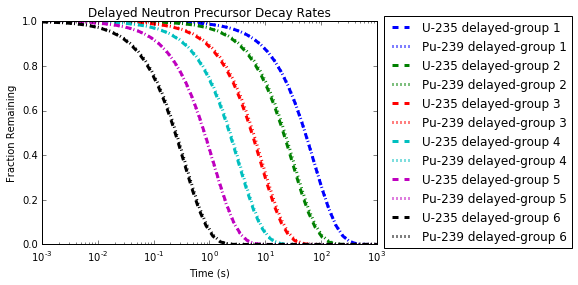

In [23]:
# Get the decay rate data
dr_tally = decay_rate.xs_tally
dr_u235 = dr_tally.get_values(nuclides=['U235']).flatten()
dr_pu239 = dr_tally.get_values(nuclides=['Pu239']).flatten()

# Compute the exponential decay of the precursors
time = np.logspace(-3,3)
dr_u235_points = np.exp(-np.outer(dr_u235, time))
dr_pu239_points = np.exp(-np.outer(dr_pu239, time))

# Create a plot of the fraction of the precursors remaining as a f(time)
colors = ['b', 'g', 'r', 'c', 'm', 'k']
for g,c in enumerate(colors):
    plt.semilogx(time, dr_u235_points [g,:], color=c, linestyle='--', linewidth=3)
    plt.semilogx(time, dr_pu239_points[g,:], color=c, linestyle=':' , linewidth=3)

plt.title('Delayed Neutron Precursor Decay Rates')
plt.xlabel('Time (s)')
plt.ylabel('Fraction Remaining')
plt.legend(['U-235 delayed-group 1', 'Pu-239 delayed-group 1', 'U-235 delayed-group 2', 'Pu-239 delayed-group 2', 
            'U-235 delayed-group 3', 'Pu-239 delayed-group 3', 'U-235 delayed-group 4', 'Pu-239 delayed-group 4', 
            'U-235 delayed-group 5', 'Pu-239 delayed-group 5', 'U-235 delayed-group 6', 'Pu-239 delayed-group 6'],
           loc=1, bbox_to_anchor=(1.6, 1.05))

Now let's compute the initial concentration of the delayed neutron precursors:

In [24]:
# Use tally arithmetic to compute the precursor concentrations
precursor_conc = beta.get_condensed_xs(one_group).xs_tally.summation(filter_type='energy', remove_filter=True) * \
    delayed_nu_fission.get_condensed_xs(one_group).xs_tally.summation(filter_type='energy', remove_filter=True) / \
    decay_rate.xs_tally.summation(filter_type='energy', remove_filter=True)

# Get the Pandas DataFrames for inspection
precursor_conc.get_pandas_dataframe()

,cell,delayedgroup,nuclide,score,mean,std. dev.
0,1,1,U235,(((delayed-nu-fission / nu-fission) * (delayed...,8.779406e-08,2.310240e-08
1,1,1,Pu239,(((delayed-nu-fission / nu-fission) * (delayed...,7.150041e-09,3.854534e-09
2,1,2,U235,(((delayed-nu-fission / nu-fission) * (delayed...,9.528171e-07,1.124883e-07
3,1,2,Pu239,(((delayed-nu-fission / nu-fission) * (delayed...,1.303200e-07,3.422243e-08
4,1,3,U235,(((delayed-nu-fission / nu-fission) * (delayed...,2.353975e-07,3.367779e-08
5,1,3,Pu239,(((delayed-nu-fission / nu-fission) * (delayed...,2.032960e-08,5.622830e-09
6,1,4,U235,(((delayed-nu-fission / nu-fission) * (delayed...,4.720335e-07,4.240950e-08
7,1,4,Pu239,(((delayed-nu-fission / nu-fission) * (delayed...,2.626392e-08,5.152078e-09
8,1,5,U235,(((delayed-nu-fission / nu-fission) * (delayed...,2.828001e-08,4.006859e-09
9,1,5,Pu239,(((delayed-nu-fission / nu-fission) * (delayed...,2.430664e-09,6.573695e-10


We can plot the delayed neutron fractions for each nuclide.

Beta (U-235) : 0.006504 +/- 0.000007
Beta (Pu-239): 0.002245 +/- 0.000002


(0, 7)

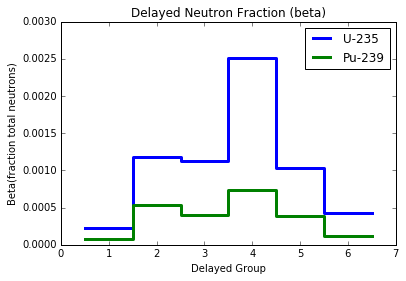

In [25]:
energy_filter = [f for f in beta.xs_tally.filters if f.type == 'energy']
beta_integrated = beta.get_condensed_xs(one_group).xs_tally.summation(filter_type='energy', remove_filter=True)
beta_u235  = beta_integrated.get_values(nuclides=['U235'])
beta_pu239 = beta_integrated.get_values(nuclides=['Pu239'])

# Reshape the betas
beta_u235.shape = (beta_u235.shape[0])
beta_pu239.shape = (beta_pu239.shape[0])

df = beta_integrated.summation(filter_type='delayedgroup', remove_filter=True).get_pandas_dataframe()
print('Beta (U-235) : {:.6f} +/- {:.6f}'.format(df[df['nuclide'] == 'U235']['mean'][0], df[df['nuclide'] == 'U235']['std. dev.'][0]))
print('Beta (Pu-239): {:.6f} +/- {:.6f}'.format(df[df['nuclide'] == 'Pu239']['mean'][1], df[df['nuclide'] == 'Pu239']['std. dev.'][1]))

beta_u235 = np.append(beta_u235[0], beta_u235)
beta_pu239 = np.append(beta_pu239[0], beta_pu239)

# Create a step plot for the MGXS
plt.plot(np.arange(0.5, 7.5, 1), beta_u235, drawstyle='steps', color='b', linewidth=3)
plt.plot(np.arange(0.5, 7.5, 1), beta_pu239, drawstyle='steps', color='g', linewidth=3)

plt.title('Delayed Neutron Fraction (beta)')
plt.xlabel('Delayed Group')
plt.ylabel('Beta(fraction total neutrons)')
plt.legend(['U-235', 'Pu-239'])
plt.xlim([0,7])

We can also plot the energy spectrum for fission emission of prompt and delayed neutrons.

(0.001, 20)

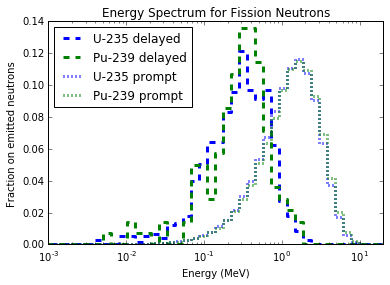

In [26]:
chi_d_u235  = np.squeeze(chi_delayed.get_xs(nuclides=['U235'], order_groups='decreasing'))
chi_d_pu239 = np.squeeze(chi_delayed.get_xs(nuclides=['Pu239'], order_groups='decreasing'))
chi_p_u235  = np.squeeze(chi_prompt.get_xs(nuclides=['U235'], order_groups='decreasing'))
chi_p_pu239 = np.squeeze(chi_prompt.get_xs(nuclides=['Pu239'], order_groups='decreasing'))

chi_d_u235  = np.append(chi_d_u235 , chi_d_u235[0])
chi_d_pu239 = np.append(chi_d_pu239, chi_d_pu239[0])
chi_p_u235  = np.append(chi_p_u235 , chi_p_u235[0])
chi_p_pu239 = np.append(chi_p_pu239, chi_p_pu239[0])

# Create a step plot for the MGXS
plt.semilogx(energy_groups.group_edges, chi_d_u235 , drawstyle='steps', color='b', linestyle='--', linewidth=3)
plt.semilogx(energy_groups.group_edges, chi_d_pu239, drawstyle='steps', color='g', linestyle='--', linewidth=3)
plt.semilogx(energy_groups.group_edges, chi_p_u235 , drawstyle='steps', color='b', linestyle=':', linewidth=3)
plt.semilogx(energy_groups.group_edges, chi_p_pu239, drawstyle='steps', color='g', linestyle=':', linewidth=3)

plt.title('Energy Spectrum for Fission Neutrons')
plt.xlabel('Energy (MeV)')
plt.ylabel('Fraction on emitted neutrons')
plt.legend(['U-235 delayed', 'Pu-239 delayed', 'U-235 prompt', 'Pu-239 prompt'],loc=2)
plt.xlim(0.001,20)